In [26]:
import degirum as dg, dgtools
import performance_measure_util as putil
import performance_measure as pmes
import time

In [27]:
#data_dir = '/home/gotom/data_dir/performance_measure/'
data_dir = '../../../data_dir/performance_measure/'
#image_file = '../../images/ThreePersons.jpg'
image_file = '../../images/TwoCats.jpg'
#image_file = '../../images/Black.jpg'

image_file_name = image_file.replace('../../images/', '')
use_jpeg = True  # use JPEG or bitmap model input
exclude_preprocessing = True  # exclude preprocessing step from timing measurements
batch_sizes = [2, 4, 8, 16]  # eager batch sizes to test
batch_strs = ['2', '4', '8', '16']

In [28]:
hand_det_model = 'yolo_v5s_hand_det--512x512_quant_n2x_orca1_1'
face_det_model = 'yolo_v5s_face_det--512x512_quant_n2x_orca1_1'
person_det_model = 'yolo_v5s_person_det--512x512_quant_n2x_orca1_1'
pose_det_model = 'mobilenet_v1_posenet_coco_keypoints--353x481_quant_n2x_orca1_1'
segmentation_model = "deeplab_seg--513x513_quant_n2x_orca1_1"

In [29]:
#target = dg.LOCAL
target = dg.CLOUD
hand_det_zoo = face_det_zoo = person_det_zoo = pose_det_zoo = segmentation_zoo = dg.connect(target, dgtools.get_cloud_zoo_url(), dgtools.get_token())

mode:            Series
Device:          @cloud
iterations:      100
model_name1:     yolo_v5s_person_det--512x512_quant_n2x_orca1_1
model_name2:     deeplab_seg--513x513_quant_n2x_orca1_1
image_file_name: TwoCats.jpg
expected_fps:    {2: 25.4, 4: 25.4, 8: 25.9, 16: 27.0}
observed_fps:    {2: 4.1, 4: 4.9, 8: 10.0, 16: 13.1}



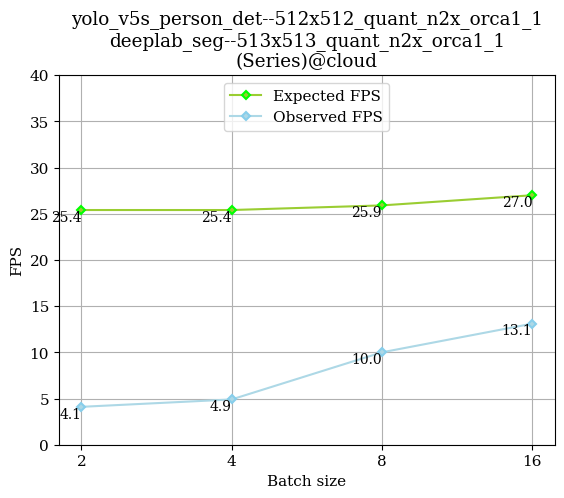

In [30]:
import importlib
importlib.reload(putil)
importlib.reload(pmes)
import time

#test_cycles = 50
test_cycles = 1

iterations = 100

#multi models (series)  
# model_symbols = ['face_hand_det', 'person_hand_det', 'pose_hand_det', 'person_pose_det'] 
# model_names = [[face_det_model, hand_det_model], [person_det_model, hand_det_model], [pose_det_model, hand_det_model],\
#                 [person_det_model, pose_det_model]] \
               
# zoo_names = [[face_det_zoo, hand_det_zoo], [person_det_zoo, hand_det_zoo], [pose_det_zoo, hand_det_zoo],\
#               [person_det_zoo, pose_det_zoo]]

model_symbols = ['person_det & segmentation']  
model_names = [[person_det_model, segmentation_model]]
zoo_names = [[person_det_zoo, segmentation_zoo]]

# model_symbols = ['face_hand_det'] 
# model_names = [[face_det_model, hand_det_model]]
# zoo_names = [[face_det_zoo, hand_det_zoo]]

arr_save = False
d = time.strftime('%m%d%H%M') 
suffix_org = 'series'

file = data_dir + 'test_results(series(x2))' + d + '.txt'

for i in range(len(model_names)):

    model_instances = []
    model_name_disps = []
    observed_fps = {}
    expected_fps = {}
    device_temp = {}
    items_dic = {}
    
    ymax = 40
    #ymax = 100
    model_instances = putil.create_model_instances(model_names[i], zoo_names[i], use_jpeg)

    for model_name in model_names[i]:
        disp = model_name.replace('/home/gotom/model_zoo/', '')
        model_name_disps.append(disp)

    for batch in batch_sizes:
        suffix = suffix_org + '(' + str(batch) + ')'
        results = pmes.series_models_fps_measure(data_dir, test_cycles, iterations, model_name_disps, model_instances, image_file, \
                              exclude_preprocessing, batch, model_symbols[i], suffix, arr_save)
        
        observed_fps[batch] = results['observed_fps']
        expected_fps[batch] = results['expected_fps']
        device_temp[batch] = results['device_temp']
        
    items_dic['mode'] = 'Series'
    items_dic['Device'] = target
    items_dic['iterations'] = iterations
    items_dic['model_name1'] = model_name_disps[0]
    items_dic['model_name2'] = model_name_disps[1]
    items_dic['image_file_name'] = image_file_name
    
    putil.show_results(items_dic, expected_fps, observed_fps)
    
    # import time
    # d = time.strftime('%m%d%H%M') 
    # suffix = items_dic['mode']
    # file = data_dir + 'test_results(series(x2))' + d + '.txt'
    
    if i == 0:
        file_obj = open(file, 'w', encoding = 'utf-8')
    
    else:
        file_obj = open(file, 'a', encoding = 'utf-8')
    
    putil.save_results(file_obj, items_dic, expected_fps, observed_fps)
    
    model_name_str = ''
    for model_name in model_name_disps:
        model_name_str += model_name + '\n'

    model_name_str += '(Series)' + target

    putil.draw_graph(data_dir, model_name_str, model_symbols[i], batch_strs, observed_fps, expected_fps, device_temp, ymax, suffix)

